## Imports & Declarations

In [1]:
import tensorflow as tf
from tensorflow import keras

import os
import gc
import tempfile
from pickle import dump, load

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap

from sklearn.preprocessing import MinMaxScaler

from datetime import datetime
from pandas.tseries.offsets import DateOffset
from ace_ai_shap_multioutput_v7_addplot import *

c:\python\python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Pre-defined Parameters

In [2]:
n_samples = 100

### Display Configuration

In [3]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display


### Data Input

In [4]:
# input file
train_file = 'data/DP_Phase4_combined_v3_train.csv'
test_file = 'data/DP_Phase4_combined_v3_test.csv'

# Model files
model_name = '3m'
features_file = 'saved_model/featurelist_{}.csv'.format(model_name)
scaler_file = 'saved_model/scaler_{}.pkl'.format(model_name)
model_file = 'saved_model/phase4_{}_model'.format(model_name)
kmeans_file = 'saved_model/kmeans_{}.pkl'.format(model_name)
featdict_file = 'saved_model/features_dict_{}.pkl'.format(model_name)
exclusion_file = 'Intermediate_tables/ACE_Final_Model_ExclusionFeatures.xlsx'
target_file = 'Intermediate_tables/ACE_Target_Map.csv'
map_file = 'Intermediate_tables/ACE_Feature_Map.csv'

target_col = [
    'Cerebral_Vascular_Accident', 'Diabetes_Mellitus',
    'Dyslipidaemia', 'Heart_and_Circulatory', 'Hypertension',
    'Osteoporosis', 'Renal_Disease', 'Osteoarthritis', 'Deceased'
]

prior_diag_col = ["Cerebral_Vascular_Accident_Diagnosed","Cerebral_Vascular_Accident_Medication",
                  "Cerebral_Vascular_Accident_Test","Diabetes_Mellitus_Diagnosed","Diabetes_Mellitus_Medication",
                  "Diabetes_Mellitus_Test","Dyslipidaemia_Diagnosed","Dyslipidaemia_Medication","Dyslipidaemia_Test",
                  "Heart_and_Circulatory_Diagnosed","Heart_and_Circulatory_Medication","Heart_and_Circulatory_Test",
                  "Hypertension_Diagnosed","Hypertension_Medication","Hypertension_Test","Osteoporosis_Diagnosed",
                  "Osteoporosis_Medication","Osteoporosis_Test","Osteoarthritis_Diagnosed","Osteoarthritis_Medication",
                  "Osteoarthritis_Test","Renal_Disease_Diagnosed","Renal_Disease_Medication","Renal_Disease_Test",
                  "Deceased_Diagnosed","Deceased_Medication","Deceased_Test"
]

prior_diag_drop = ["Cerebral_Vascular_Accident_Test", "Cerebral_Vascular_Accident_Medication",
                  "Heart_and_Circulatory_Medication", "Heart_and_Circulatory_Test",
                  "Hypertension_Test",
                  "Osteoporosis_Test",
                  "Osteoarthritis_Medication", "Osteoarthritis_Test",
                  "Renal_Disease_Medication",
                  "Deceased_Diagnosed","Deceased_Medication","Deceased_Test"
]

target_prior_col = [target+'_Prior' for target in target_col[:-1]]

# SHAP parameters
non_periodic_features = ['PAT_AGE', 'GENDER_Male', 'GENDER_Female', 
                         'RACE_Chinese', 'RACE_Malay', 'RACE_Indian', 'RACE_Others',
                         "Cancer_Prior","Cerebral_Vascular_Accident_Prior","Diabetes_Mellitus_Prior",
                         "Dyslipidaemia_Prior","Heart_and_Circulatory_Prior","Hypertension_Prior",
                         "Osteoporosis_Prior","Renal_Disease_Prior","OverWeight_Prior",
                         "Osteoarthritis_Prior","BPH_Prior","COPD_Prior","Epilepsy_Prior","HepB_Prior",
                         "Parkinson_Prior","Psoriasis_Prior","RA_Prior","Allergic_Prior","Asthma_Prior",
                         "Dementia_Prior","Gout_Prior"
] + prior_diag_col

# features to drop
feature_to_drop = ['PAT_ID'] + target_col + target_prior_col + prior_diag_drop

# validation data size
val_size=1000

BATCH_SIZE = 512
feature_periods = ['YEARH_', 'YEAR1_', 'YEAR1H_', 'YEAR2_', 'YEAR2H_', 'YEAR3_']

## Import data

In [5]:
# data files
feature_names = pd.read_csv(features_file)['Feature name'].tolist()
train = pd.read_csv(train_file, usecols=feature_to_drop+feature_names)

# test = pd.read_csv(test_file, usecols=feature_to_drop+feature_names)
# train = pd.concat([train, test], axis=0, ignore_index=True)

## Process Data

In [6]:
# Define process function, combine scaler
def data_proc_X(data, feature_names, scaler_file=None):
    X = data[feature_names]
    X.fillna(-1, inplace=True)  # Fill in missing with -1
    X = np.asarray(X)  # Convert to array
    
    if scaler_file is None:
        X = X
    else:
        scaler = load(open(scaler_file, 'rb'))  # Load scaler
        X = scaler.transform(X)  # Scale data
    return X

## Load Model and Scaler

In [7]:
model = keras.models.load_model(model_file, compile=False)
scaler = load(open(scaler_file, 'rb'))

Trying to unpickle estimator MinMaxScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.


In [8]:
model.summary()

Model: "Model_3m"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 275)]             0         
                                                                 
 hidden1 (Dense)             (None, 1024)              282624    
                                                                 
 hidden2 (Dense)             (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 output_layer (Dense)        (None, 9)                 4617      
                                                                 
Total params: 812,041
Trainable params: 812,041
Non-trainable params: 0
_________________________________________________________________


In [9]:
train_kmeans = load(open(kmeans_file, 'rb'))
features_dict = load(open(featdict_file, 'rb'))

## Prediction

In [10]:
# prediction using processed data
def only_predict(model, test_features_scaled, data, BATCH_SIZE):
    start_time = datetime.now()
    test_predictions = model.predict(test_features_scaled, batch_size=BATCH_SIZE)
    print(test_predictions.shape)
    end_time = datetime.now()
    print("predictions took ", end_time - start_time)
    
    # [BW]: use original input values, not processed ones
    # Create data frame with feature values and predictions for all patients
    test_df = data.copy() 
    test_df['Deceased_Prior'] = 0
    
    # get prediction probabilities: rescale
    for i, target in enumerate(target_col):
        test_df[target + '_Proba'] = test_predictions[:,i]
        
    return test_df


# Prediction starting from data processing
def make_predict(model, data, feature_names, scaler_file):
    # Process data
    test_features_scaled = data_proc_X(data, feature_names, scaler_file)
    print('Test features shape:', test_features_scaled.shape)
    
    # Predict 
    test_df = only_predict(model, test_features_scaled, data, BATCH_SIZE)
    
    return test_df

In [1]:
test_df = make_predict(model, train, feature_names, scaler_file)
test_df.head()

## Analyse top predictions

### True positive cases

In [12]:
tp_pats = {}
for target in target_col:
    print(target)
    pat_list =test_df[(test_df[target+'_Prior']==0)&(test_df[target]==1)].sort_values(target+'_Proba', ascending=False).head(1000)
#     display(pat_list)
    print()
    tp_pats[target] = list(pat_list.index)

Cerebral_Vascular_Accident

Diabetes_Mellitus

Dyslipidaemia

Heart_and_Circulatory

Hypertension

Osteoporosis

Renal_Disease

Osteoarthritis

Deceased



Cerebral_Vascular_Accident



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [17:07<00:00, 10.28s/it]


Generating SHAP explanation for 100 samples and re-evaluating 500 times. 


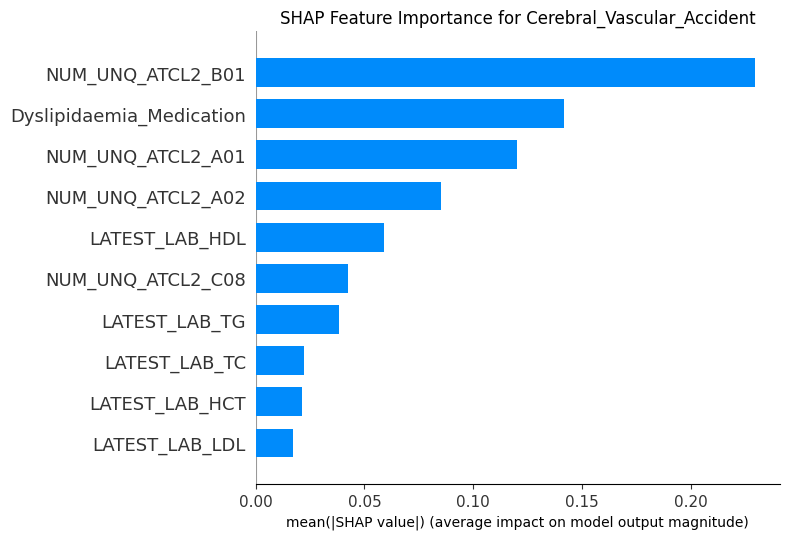

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


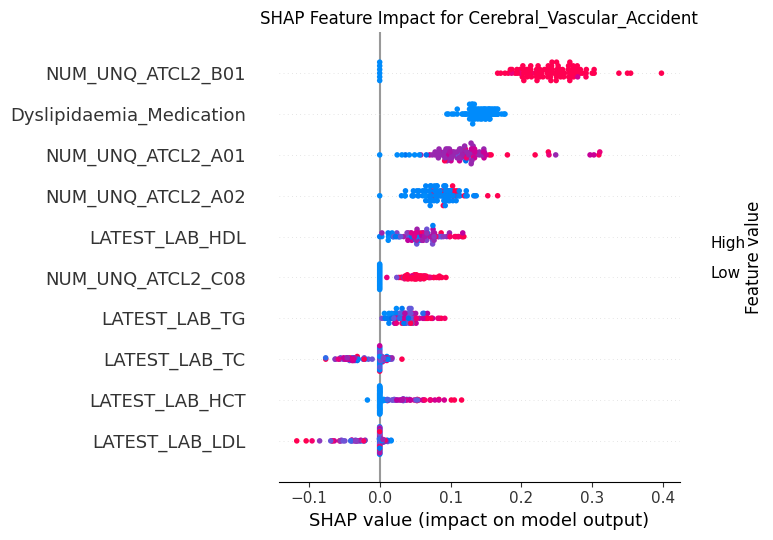

Cerebral_Vascular_Accident saved
Diabetes_Mellitus



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [13:53<00:00,  8.34s/it]


Generating SHAP explanation for 100 samples and re-evaluating 500 times. 


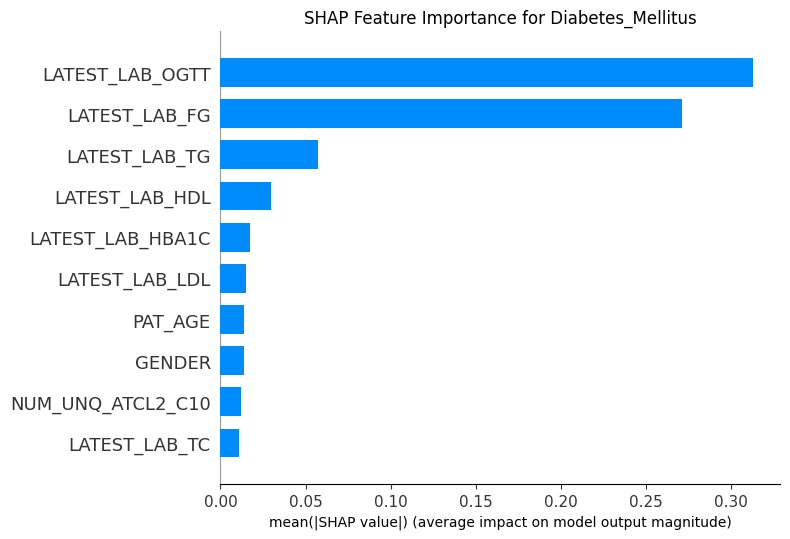

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


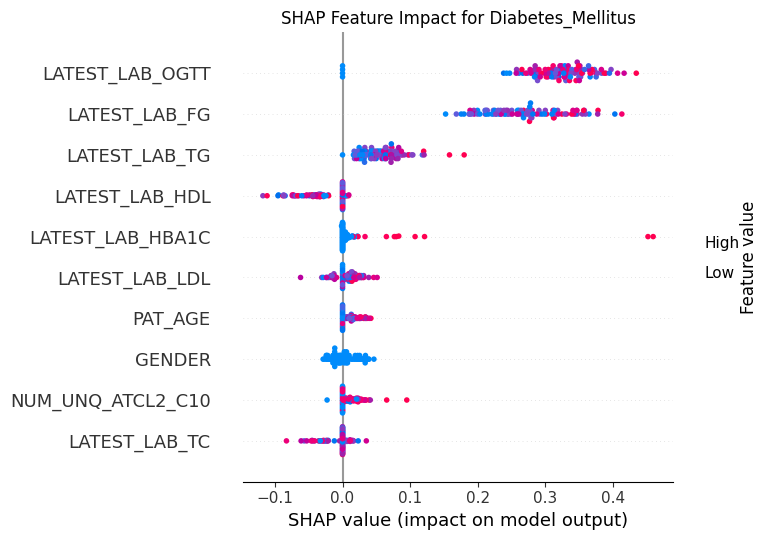

Diabetes_Mellitus saved
Dyslipidaemia



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [11:01<00:00,  6.62s/it]


Generating SHAP explanation for 100 samples and re-evaluating 500 times. 


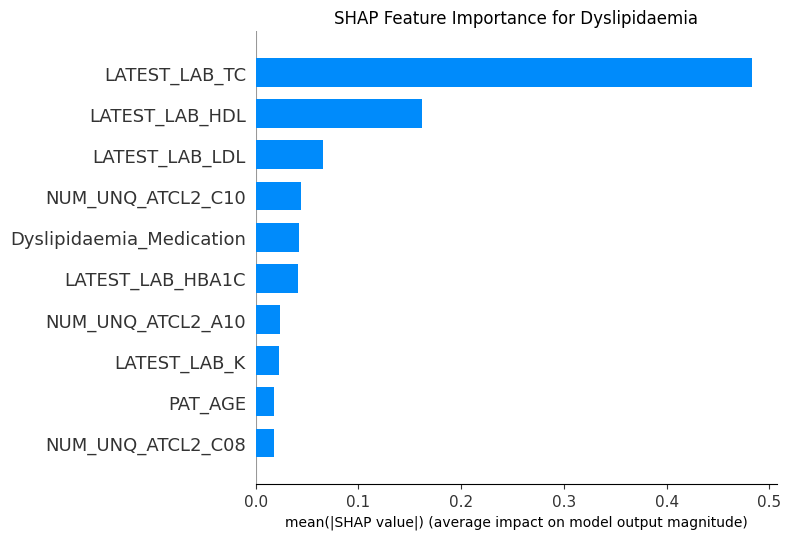

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


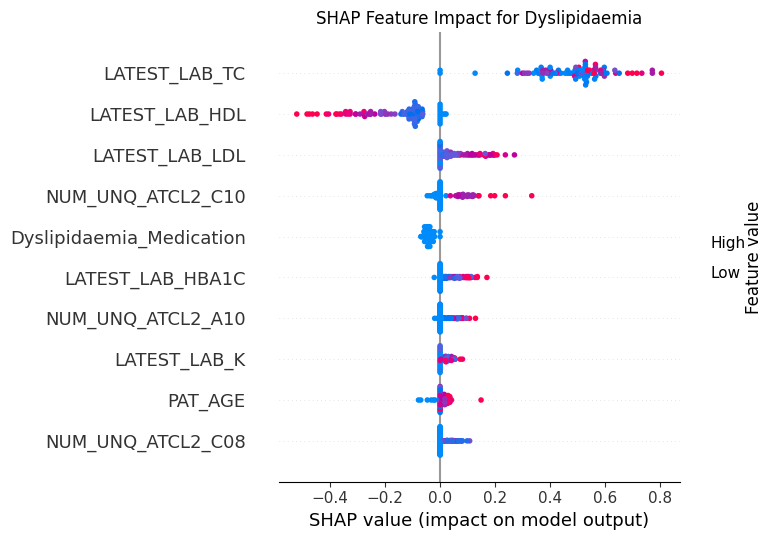

Dyslipidaemia saved
Heart_and_Circulatory



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [16:42<00:00, 10.03s/it]


Generating SHAP explanation for 100 samples and re-evaluating 500 times. 


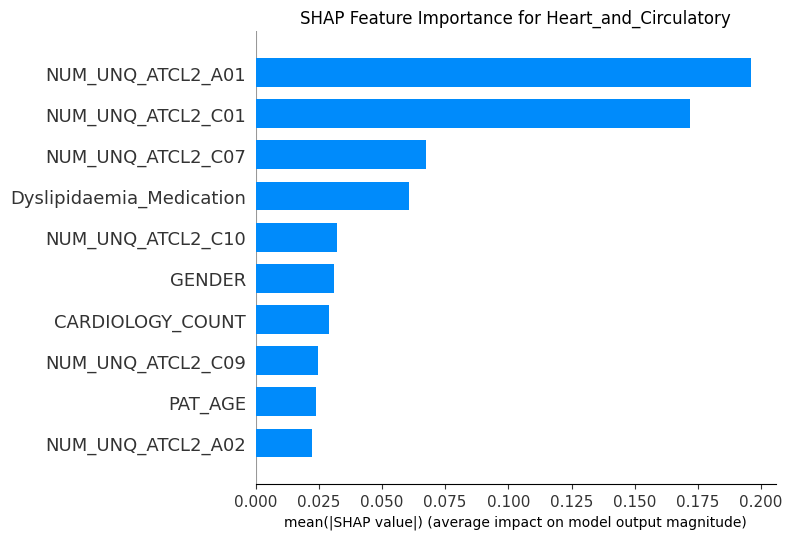

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


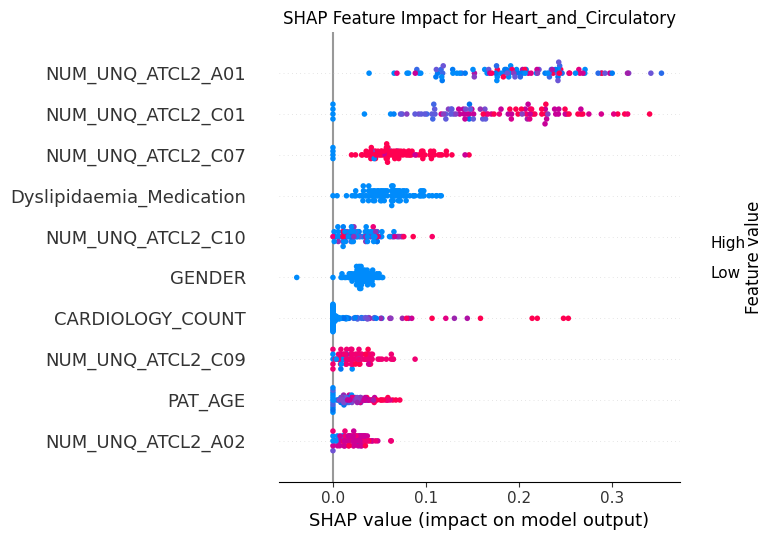

Heart_and_Circulatory saved
Hypertension



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:56<00:00,  1.76s/it]


Generating SHAP explanation for 100 samples and re-evaluating 500 times. 


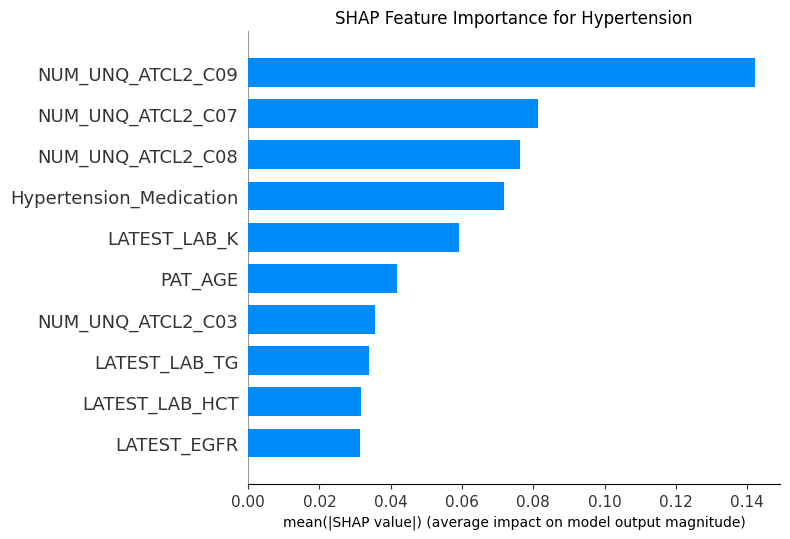

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


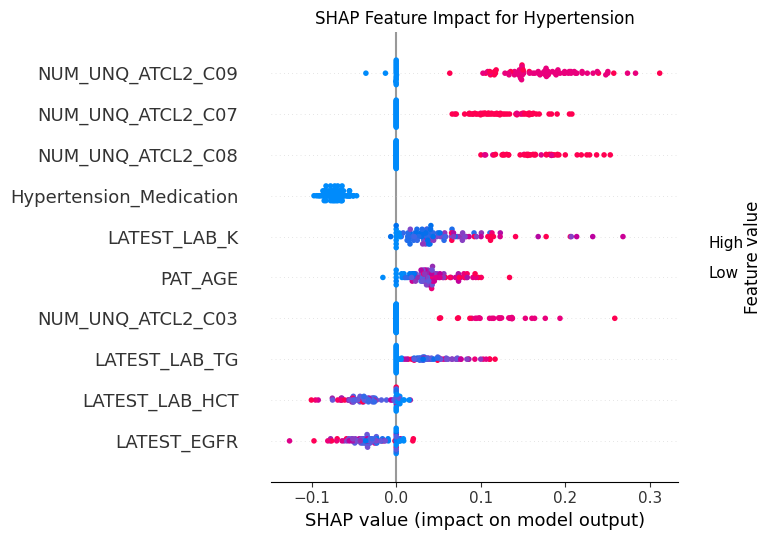

Hypertension saved
Osteoporosis



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:16<00:00,  1.97s/it]


Generating SHAP explanation for 100 samples and re-evaluating 500 times. 


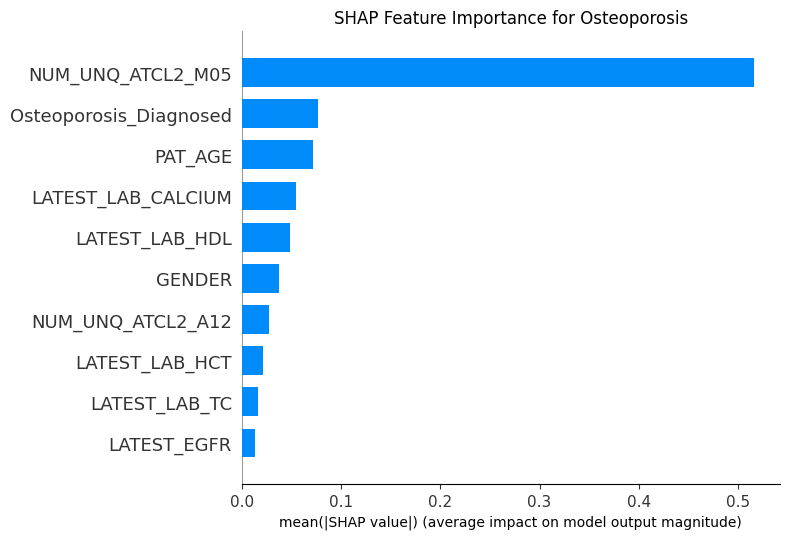

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


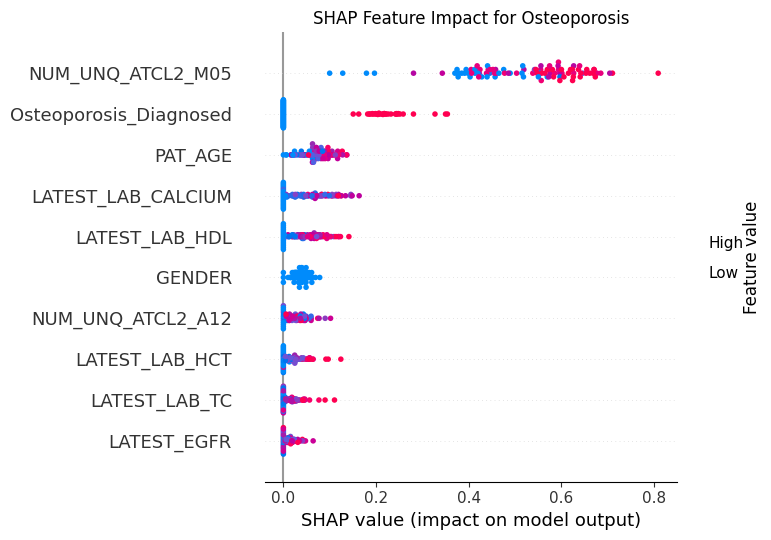

Osteoporosis saved
Renal_Disease



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:59<00:00,  1.79s/it]


Generating SHAP explanation for 100 samples and re-evaluating 500 times. 


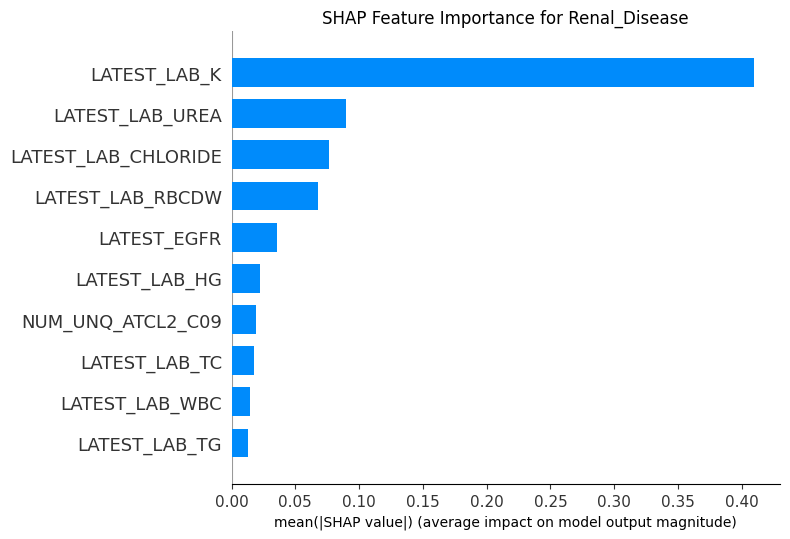

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


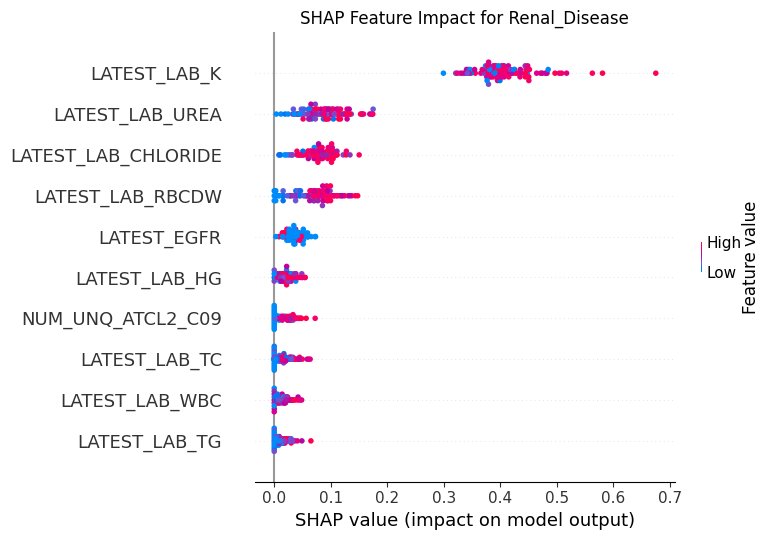

Renal_Disease saved
Osteoarthritis



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:09<00:00,  1.89s/it]


Generating SHAP explanation for 100 samples and re-evaluating 500 times. 


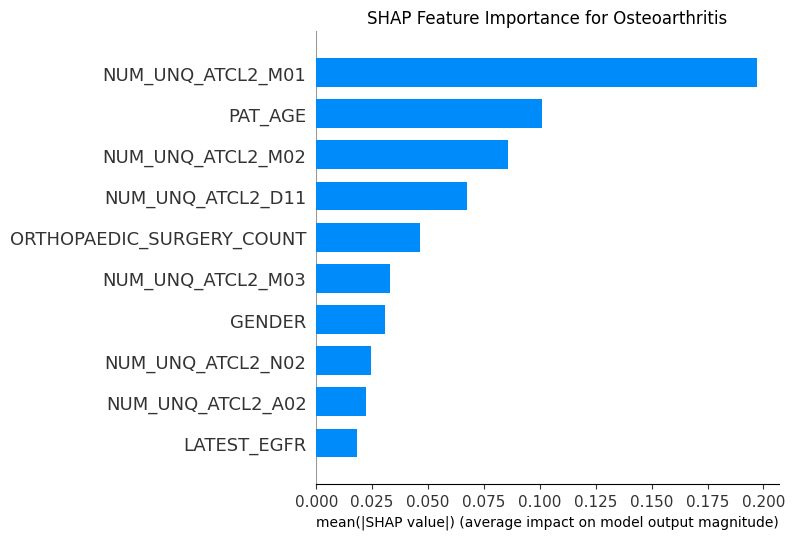

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


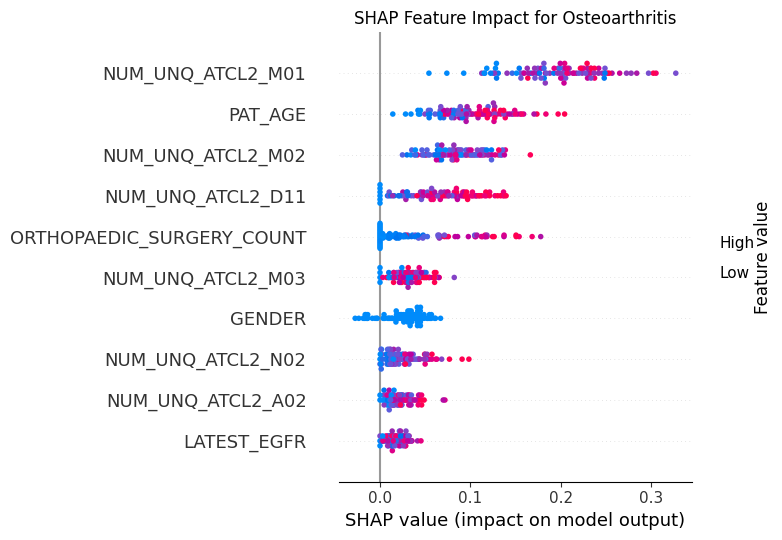

Osteoarthritis saved


In [13]:
bar_plots = []
beeswarm_plots = []

for target in target_col[:-1]:
    print(target)
    df = train.iloc[tp_pats[target], :]
    # Instantiate the DeepPatientShap class --> Only need to instantiate once
    shap_explain = DeepPatientShap(
        scaler=scaler,
        model=model,
        X_train_kmeans=train_kmeans,  # summarized dataset
        X_test=data_proc_X(df, feature_names),  # dataset to generate feature importance for (ie production data)
        features=feature_names,
        targets=target_col,
        full_targets=target_col,
        categorical_features={
            'GENDER': ['GENDER_Male', 'GENDER_Female'],
            'RACE': ['RACE_Chinese', 'RACE_Malay', 'RACE_Indian', 'RACE_Others'],
        },
        ex_features=non_periodic_features,
        features_dict=features_dict,
        )
    shap_explain.shap_explainer_generator_multiple(num_samples=n_samples)
    
    # Create and display bar plot
    bar_plot = shap_explain.plot_shap_bar(target=target, max_display=10, save_path=f"barplots/barplot_{target}.png")
    bar_plots.append(bar_plot)
    plt.show()
    
    # Create and display beeswarm plot
    beeswarm_plot = shap_explain.plot_shap_beeswarm(target=target, max_display=10, save_path=f"beeswarmplots/beeswarm_{target}.png")
    beeswarm_plots.append(beeswarm_plot)
    plt.show()

    feat_df = shap_explain.shap_top_features_multiple(target, num_features=1000)
    
    feat_df.to_csv(f'Model{model_name}_SHAP_imp_TP_{target}_Oct2025.csv', index=False)
    print(target, "saved")    
